# Mixed ordered logit

We begin by performing the necessary imports:

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.path.insert(0, "/home/rodr/code/amortized-mxl-dev/release") 

import logging
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Fix random seed for reproducibility
np.random.seed(42)

## Import previously simulated data

For this demo, we will use previously generated simulated data. Since this is artificial data, we actually know the parameter values that were used to generate the choices: [1, -1, 1, -1]. The (log) cutoff points used to generate the data were: [-0.7 -0.2  0.5]. Our goal is to see whether our model implementation can accurately recover the true parameters that were used to generate the data. 

In [2]:
df = pd.read_csv('../data/fake_data_ordered.csv', index_col=0)
num_resp = len(df)
df['indID'] = np.arange(num_resp)
df.head()

,choice,x0,x1,x2,x3,indID
0,0,1.0,0.585995,0.667338,0.681352,0
1,0,1.0,0.476451,0.026819,0.443944,1
2,0,1.0,0.753613,0.768395,0.468803,2
3,2,1.0,0.605222,0.862393,0.434364,3
4,0,1.0,0.142990,0.001069,0.608124,4


## Mixed Logit specification

We now make use of the developed formula interface to specify the utilities of the mixed logit model. 

We begin by defining the fixed effects parameters, the random effects parameters, and the observed variables. This creates instances of Python objects that can be put together to define the utility functions for the different alternatives.

Once the utilities are defined, we collect them in a Python dictionary mapping alternative names to their corresponding expressions.

Note that, since this is an ordinal regression model, there is only one single utility. The observed values correspond to different "levels" of the response variable. 

In [3]:
from core.dcm_interface import FixedEffect, RandomEffect, ObservedVariable
import torch.distributions as dists

# define fixed effects parameters
B_X0 = FixedEffect('BETA_X0')
B_X1 = FixedEffect('BETA_X1')

# define random effects parameters
B_X2 = RandomEffect('BETA_X2')
B_X3 = RandomEffect('BETA_X3')

# define observed variables
for attr in df.columns:
    exec("%s = ObservedVariable('%s')" % (attr,attr))

# define utility functions
V1 = B_X0*x0 + B_X1*x1 + B_X2*x2 + B_X3*x3

# associate utility functions with the names of the alternatives
utilities = {"ALT1": V1}

We are now ready to create a Specification object containing the utilities that we have just defined. Note that we must also specify the type of choice model to be used - a mixed logit model (MXL) in this case.

Note that we can inspect the specification by printing the dcm_spec object.

In [4]:
from core.dcm_interface import Specification

#Logit(choice, utilities, availability, df)
#Logit(choice_test, utilities, availability_test, df_test)

# create MXL specification object based on the utilities previously defined
dcm_spec = Specification('MXL', utilities)
print(dcm_spec)

----------------- MXL specification:
Alternatives: ['ALT1']
Utility functions:
   V_ALT1 = BETA_X0*x0 + BETA_X1*x1 + BETA_X2_n*x2 + BETA_X3_n*x3

Num. parameters to be estimated: 4
Fixed effects params: ['BETA_X0', 'BETA_X1']
Random effects params: ['BETA_X2', 'BETA_X3']


Once the Specification is defined, we need to define the DCM Dataset object that goes along with it. For this, we instantiate the Dataset class with the Pandas dataframe containing the data in the so-called "wide format", the name of column in the dataframe containing the observed choices and the dcm_spec that we have previously created.

Note that since this is panel data, we must also specify the name of the column in the dataframe that contains the ID of the respondent (this should be a integer ranging from 0 the num_resp-1).

In [5]:
from core.dcm_interface import Dataset

# create DCM dataset object
dcm_dataset = Dataset(df, 'choice', dcm_spec, resp_id_col='indID')

Preparing dataset...
	Model type: MXL
	Num. observations: 10000
	Num. alternatives: 1
	Num. respondents: 10000
	Num. menus: 1
	Observations IDs: [   0    1    2 ... 9997 9998 9999]
	Alternative IDs: None
	Respondent IDs: [   0    1    2 ... 9997 9998 9999]
	Availability columns: None
	Attribute names: ['x0', 'x1', 'x2', 'x3']
	Fixed effects attribute names: ['x0', 'x1']
	Fixed effects parameter names: ['BETA_X0', 'BETA_X1']
	Random effects attribute names: ['x2', 'x3']
	Random effects parameter names: ['BETA_X2', 'BETA_X3']
	Alternative attributes ndarray.shape: (10000, 1, 4)
	Choices ndarray.shape: (10000, 1)
	Alternatives availability ndarray.shape: (10000, 1, 1)
	Data mask ndarray.shape: (10000, 1)
	Context data ndarray.shape: (10000, 0)
	Neural nets data ndarray.shape: (10000, 0)
Done!


As with the specification, we can inspect the DCM dataset by printing the dcm_dataset object:

In [6]:
print(dcm_dataset)

----------------- DCM dataset:
Model type: MXL
Num. observations: 10000
Num. alternatives: 1
Num. respondents: 10000
Num. menus: 1
Num. fixed effects: 2
Num. random effects: 2
Attribute names: ['x0', 'x1', 'x2', 'x3']


## Bayesian Mixed Ordered Logit Model in PyTorch

We will modify the generative process of the core MXL model by introducing a vector of $C-2$ cutoff points $\boldsymbol\kappa$, where $C$ denotes the number of levels in the response variable. The cutoffs will then be used by the ``OrderedLogit`` function to compute the probabilities of each level. 

The resulting generative process is the following (changes to the core MXL model are highlighted in red):

1. <font color='red'> Draw cutoff parameters $\boldsymbol\kappa \sim \mathcal{N}(\boldsymbol\eta_0, \boldsymbol\Phi_0)$ </font>
2. Draw fixed taste parameters $\boldsymbol\alpha \sim \mathcal{N}(\boldsymbol\lambda_0, \boldsymbol\Xi_0)$
3. Draw mean vector $\boldsymbol\zeta \sim \mathcal{N}(\boldsymbol\mu_0, \boldsymbol\Sigma_0)$
4. Draw scales vector $\boldsymbol\theta \sim \mbox{half-Cauchy}(\boldsymbol\sigma_0)$
5. Draw correlation matrix $\boldsymbol\Psi \sim \mbox{LKJ}(\nu)$
6. For each decision-maker $n \in \{1,\dots,N\}$
    1. Draw random taste parameters $\boldsymbol\beta_n \sim \mathcal{N}(\boldsymbol\zeta,\boldsymbol\Omega)$
    2. For each choice occasion $t \in \{1,\dots,T_n\}$
        1. <font color='red'> Draw observed ordered response $y_{nt} \sim \mbox{OrderedLogit}(\boldsymbol\alpha, \boldsymbol\beta_n, \boldsymbol\kappa, \textbf{X}_{nt})$ </font>
        
where $\boldsymbol\Omega = \mbox{diag}(\boldsymbol\theta) \times \boldsymbol\Psi \times  \mbox{diag}(\boldsymbol\theta)$.

For the ``OrderedLogit`` probability, we assume:

$$
\begin{align}
p(y_{nt} = j) &= p(\kappa_{i-1} < \boldsymbol\alpha^T \textbf{x}_{ntj,F} + \boldsymbol\beta_n^T \textbf{x}_{ntj,R} < \kappa_i) \\
&= \frac{1}{1+\exp(-\kappa_i + \boldsymbol\alpha^T \textbf{x}_{ntj,F} + \boldsymbol\beta_n^T \textbf{x}_{ntj,R})} - \frac{1}{1+\exp(-\kappa_{i-1} + \boldsymbol\alpha^T \textbf{x}_{ntj,F} + \boldsymbol\beta_n^T \textbf{x}_{ntj,R})}
\end{align}
$$

where $\kappa_0$ is defined as $-\infty$ and $\kappa_C$ as $+\infty$ (hence, the number of $\kappa_i$ variables that we need to perform inference on is only $C-2$). Note that we use $\textbf{x}_{ntj,F}$ and $\textbf{x}_{ntj,R}$ to distinguish between fixed effects and random effects, respectively.

This model is already implemented in the class ``TorchMXL_Ordered``. At the end of this notebook, we provide an explanation of how this extension was implemented. 

We can instantiate this model from the ``TorchMXL_Ordered`` using the following code. We can the run variational inference to approximate the posterior distribution of the latent variables in the model. Note that since in this case we know the true parameters that were used to generate the simualated choice data, we can pass them to the "infer" method in order to obtain additional information during the ELBO maximization (useful for tracking the progress of VI and for other debugging purposes). 

[Epoch     0] ELBO: 56100; Loglik: -20462; Acc.: 0.388; Alpha RMSE: 1.000; Beta RMSE: 0.990
[Epoch   100] ELBO: 22516; Loglik: -19553; Acc.: 0.388; Alpha RMSE: 0.951; Beta RMSE: 1.046
[Epoch   200] ELBO: 24147; Loglik: -14972; Acc.: 0.388; Alpha RMSE: 0.864; Beta RMSE: 1.013
[Epoch   300] ELBO: 15727; Loglik: -13902; Acc.: 0.388; Alpha RMSE: 0.798; Beta RMSE: 0.979
[Epoch   400] ELBO: 16683; Loglik: -13879; Acc.: 0.388; Alpha RMSE: 0.709; Beta RMSE: 0.985
[Epoch   500] ELBO: 16292; Loglik: -13459; Acc.: 0.388; Alpha RMSE: 0.621; Beta RMSE: 0.962
[Epoch   600] ELBO: 16674; Loglik: -13230; Acc.: 0.388; Alpha RMSE: 0.554; Beta RMSE: 0.920
[Epoch   700] ELBO: 16519; Loglik: -13196; Acc.: 0.388; Alpha RMSE: 0.480; Beta RMSE: 0.897
[Epoch   800] ELBO: 16110; Loglik: -13011; Acc.: 0.388; Alpha RMSE: 0.441; Beta RMSE: 0.864
[Epoch   900] ELBO: 15663; Loglik: -12956; Acc.: 0.388; Alpha RMSE: 0.362; Beta RMSE: 0.842
[Epoch  1000] ELBO: 15560; Loglik: -12768; Acc.: 0.388; Alpha RMSE: 0.304; Beta 

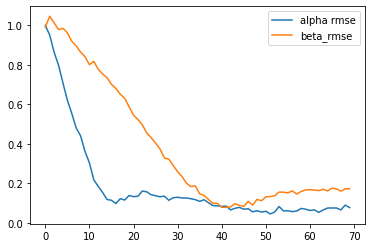

CPU times: user 21min 17s, sys: 1.53 s, total: 21min 18s
Wall time: 2min 58s


In [7]:
%%time

from core.torch_mxl_ordered import TorchMXL_Ordered

# instantiate MXL model
num_categories = 5
mxl = TorchMXL_Ordered(dcm_dataset, num_categories, batch_size=num_resp, use_inference_net=False, use_cuda=True)

# run Bayesian inference (variational inference)
results = mxl.infer(num_epochs=7000, true_alpha=np.array([1, -1]), true_beta=np.array([1, -1]))

In [30]:
# log(true_cutoffs)=[-0.7 -0.2  0.5]

Lets now compare the inferred cutoffs with the true cutoffs:
log(true_cutoffs) = [-0.7 -0.2  0.5]

The ones that we infered are:

In [11]:
torch.log(mxl.softplus(mxl.kappa_mu))

tensor([-0.6353, -0.1080,  0.5551], device='cuda:0', grad_fn=<LogBackward0>)

Quite similar values!

The "results" dictionary containts a summary of the results of variational inference, including means of the posterior approximations for the different parameters in the model:

In [33]:
results

{'Estimation time': 64.12379693984985,
 'Est. alpha': array([ 1.0848361, -0.9402135], dtype=float32),
 'Est. zeta': array([ 1.0654774, -1.1859826], dtype=float32),
 'Est. beta_n': array([[ 0.7436627 , -1.5113661 ],
        [ 1.1884117 , -1.5241228 ],
        [ 0.5740844 , -1.2508584 ],
        ...,
        [ 0.94637936, -1.5531573 ],
        [ 1.308997  , -1.1411221 ],
        [ 1.1743374 , -1.6200343 ]], dtype=float32),
 'ELBO': 14481.8515625,
 'Loglikelihood': -13628.396484375,
 'Accuracy': 0.38760000467300415}

This interface is currently being improved to include additional output information, but additional information can be obtained from the attributes of the "mxl" object for now. 

## Implementation details

TODO